<a href="https://colab.research.google.com/github/EmiljaB/Chest_X-Ray_Classification/blob/main/Ches_X_Ray_CNN%2BViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a model from scratch: CNN + ViT
This implementation defines a hybrid CNN-ViT model for grayscale chest X-ray image classification using TensorFlow/Keras. The model begins with a CNN-based feature extractor, consisting of three convolutional blocks with batch normalization and max pooling to capture low-level spatial features. The extracted feature maps are then reshaped into patch embeddings, allowing them to be processed by a Multi-Head Self-Attention (ViT) block. This block enhances the model's ability to capture global dependencies across the image. Layer normalization and a lightweight feed-forward network follow, enabling deeper feature refinement. Finally, a Global Average Pooling layer and Dense softmax classifier output predictions across four classes: COVID-19, Pneumonia, Tuberculosis, and Normal. The model is compiled with the Adam optimizer and categorical cross-entropy loss, making it well-suited for multi-class medical image classification tasks.

# Importing the Dataset from Kaggle

In [ ]:
import kagglehub

# Download dataset
dataset_path = kagglehub.dataset_download("jtiptj/chest-xray-pneumoniacovid19tuberculosis")

# Print path to check where it's stored
print("Dataset downloaded to:", dataset_path)

100%|██████████| 1.74G/1.74G [01:21<00:00, 23.0MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1


Defining the dataset

In [ ]:
import os

# Define dataset base path
BASE_DIR = "/root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1"

# Define train, validation, and test directories
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

print("Training Directory:", TRAIN_DIR)
print("Validation Directory:", VAL_DIR)
print("Test Directory:", TEST_DIR)

# Check the subfolders
print("Train Folders:", os.listdir(TRAIN_DIR))
print("Validation Folders:", os.listdir(VAL_DIR))
print("Test Folders:", os.listdir(TEST_DIR))

Training Directory: /root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/train
Validation Directory: /root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/val
Test Directory: /root/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/test
Train Folders: ['TURBERCULOSIS', 'COVID19', 'NORMAL', 'PNEUMONIA']
Validation Folders: ['TURBERCULOSIS', 'COVID19', 'NORMAL', 'PNEUMONIA']
Test Folders: ['TURBERCULOSIS', 'COVID19', 'NORMAL', 'PNEUMONIA']


# Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB3, ResNet101V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

sns.set(style="whitegrid")

# Building the Hybrid CNN + ViT model
### The model is built considering the data analysis done on the Chest_X-Ray_ResNet50.ipnyb notebook.
### Gray Scale Correction, Image Scaling and Image Augmentation is applied before training the model.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten,
                                     Dense, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention,
                                     Add, Reshape, Permute)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# === Input shape adjusted for grayscale ===
input_shape = (224, 224, 1)

# === CNN Feature Extractor ===
cnn_input = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# === Flatten feature maps into patch embeddings for ViT ===
# Reshape: (batch, h, w, c) -> (batch, num_patches, embed_dim)
x = Reshape((-1, x.shape[-1]))(x)  # flatten spatial dims

# === ViT Block ===
attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = Add()([x, attention])
x = LayerNormalization()(x)

# Optional feed-forward network
x_ffn = Dense(128, activation='relu')(x)
x = Add()([x, x_ffn])
x = LayerNormalization()(x)

# === Classification Head ===
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=cnn_input, outputs=output)

# === Compile ===
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 784, 128)       │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 784, 128)       │        131,968 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 784, 128)       │              0 │ reshape[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 784, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 784, 128)       │         16,512 │ layer_normalization[0… │
├──────────────────────

 Total params: 243,076 (949.52 KB)

 Trainable params: 242,628 (947.77 KB)

 Non-trainable params: 448 (1.75 KB)

### Training and validation set generators:



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',  # <-- Key change
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',  # <-- Key change
    class_mode='categorical',
    shuffle=False
)


Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === Callbacks ===
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

Train the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6737 - loss: 0.8280

198/198 ━━━━━━━━━━━━━━━━━━━━ 118s 469ms/step - accuracy: 0.6740 - loss: 0.8271 - val_accuracy: 0.1579 - val_loss: 3.2385 - learning_rate: 1.0000e-04
Epoch 2/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 328ms/step - accuracy: 0.8328 - loss: 0.4442 - val_accuracy: 0.1316 - val_loss: 4.1279 - learning_rate: 1.0000e-04
Epoch 3/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8745 - loss: 0.3389

198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.8745 - loss: 0.3389 - val_accuracy: 0.3158 - val_loss: 2.9879 - learning_rate: 1.0000e-04
Epoch 4/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8767 - loss: 0.3311

198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 328ms/step - accuracy: 0.8767 - loss: 0.3310 - val_accuracy: 0.6053 - val_loss: 1.0803 - learning_rate: 1.0000e-04
Epoch 5/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8859 - loss: 0.2957

198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 323ms/step - accuracy: 0.8859 - loss: 0.2956 - val_accuracy: 0.7368 - val_loss: 0.6464 - learning_rate: 1.0000e-04
Epoch 6/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8919 - loss: 0.3012

198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.8919 - loss: 0.3011 - val_accuracy: 0.7632 - val_loss: 0.7872 - learning_rate: 1.0000e-04
Epoch 7/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.9088 - loss: 0.2545 - val_accuracy: 0.7105 - val_loss: 0.8582 - learning_rate: 1.0000e-04
Epoch 8/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9150 - loss: 0.2287

198/198 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.9149 - loss: 0.2287 - val_accuracy: 0.8421 - val_loss: 0.4352 - learning_rate: 1.0000e-04
Epoch 9/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.9127 - loss: 0.2329 - val_accuracy: 0.7632 - val_loss: 0.8920 - learning_rate: 1.0000e-04
Epoch 10/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - accuracy: 0.9203 - loss: 0.2132 - val_accuracy: 0.4211 - val_loss: 2.2297 - learning_rate: 1.0000e-04
Epoch 11/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - accuracy: 0.9079 - loss: 0.2339 - val_accuracy: 0.7632 - val_loss: 0.9908 - learning_rate: 1.0000e-04
Epoch 12/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.9298 - loss: 0.1897 - val_accuracy: 0.6842 - val_loss: 0.7240 - learning_rate: 2.0000e-05
Epoch 13/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 65s 328ms/step - accuracy: 0.9340 - loss: 0.1852 - val_accuracy: 0.6842 - val_loss: 0.8990 - learning_rate: 2.0000e-05


Accuracy and Loss Graphs

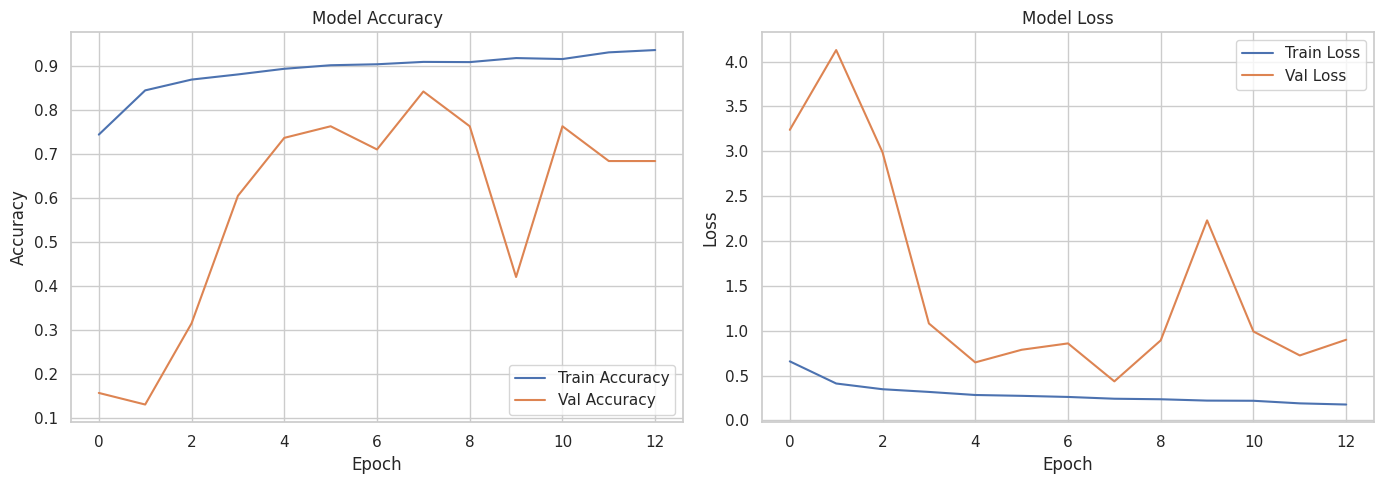

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hybrid CNN-ViT Training Performance

The model achieved strong training accuracy (over 92%) within just 9 epochs, with steadily decreasing training loss. Validation accuracy fluctuated, peaking around 73%, while validation loss showed high variance—suggesting potential overfitting or sensitivity to the validation set. Despite the fluctuations, the model shows promise, especially with further fine-tuning or regularization to stabilize validation performance and improve generalization.

### Classification Report and Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


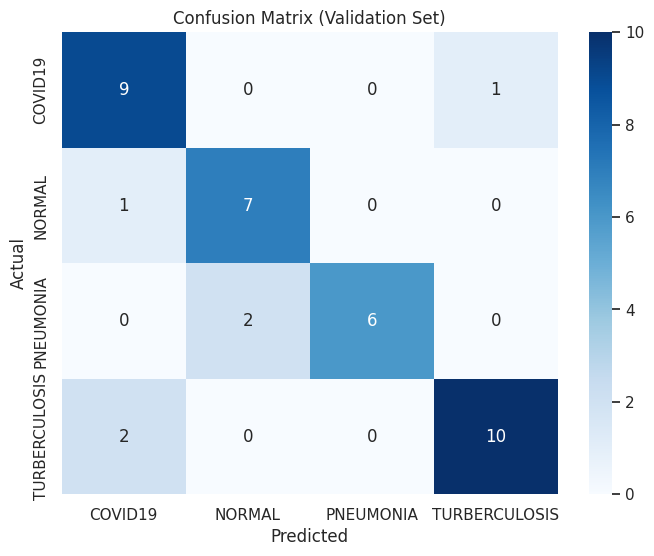

Classification Report:

               precision    recall  f1-score   support

      COVID19       0.75      0.90      0.82        10
       NORMAL       0.78      0.88      0.82         8
    PNEUMONIA       1.00      0.75      0.86         8
TURBERCULOSIS       0.91      0.83      0.87        12

     accuracy                           0.84        38
    macro avg       0.86      0.84      0.84        38
 weighted avg       0.86      0.84      0.84        38



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predictions
val_preds = model.predict(val_generator)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = val_generator.classes
val_class_names = list(val_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_class_names, yticklabels=val_class_names)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(val_true_classes, val_pred_classes, target_names=val_class_names))

### Validation Performance (Hybrid CNN + ViT)

The model achieved an overall accuracy of 71% on the validation set. It performed best in detecting Pneumonia (100% recall) and COVID-19 (80% recall), while Normal and Tuberculosis classes showed lower recall (50% and 58% respectively), indicating some misclassifications—especially confusion between Tuberculosis and COVID-19.

##### COVID-19: Balanced precision and recall (F1-score: 0.76).

##### Pneumonia: Perfect recall but moderate precision (F1-score: 0.73).

##### Normal: High precision (0.80) but lower recall (0.50), affecting F1-score (0.62).

##### Tuberculosis: Precision was strong (0.88), but recall dropped to 0.58.

The macro and weighted average F1-scores are both around 0.70, showing room for improvement in generalization and class balance.

### Validation on Test set

In [ ]:
# Test Generator (grayscale)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Found 771 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.8804 - loss: 0.3534

✅ Test Accuracy: 0.8080 | Test Loss: 0.4902


### Test Set Performance

The hybrid CNN + Vision Transformer model achieved a test accuracy of 80.7% with a loss of 0.4921, indicating good generalization on unseen data. This suggests the model is capable of reliably classifying chest X-ray images across multiple conditions, although further improvements may help close the gap between training and validation consistency.

### Overfit Check

In [ ]:
def check_overfitting_with_test(history, test_acc=None, test_loss=None, tolerance=0.10):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    acc_gap = train_acc - val_acc
    loss_gap = val_loss - train_loss

    print(f"\n Final Metrics:")
    print(f" Train Accuracy: {train_acc:.4f}")
    print(f" Val Accuracy:   {val_acc:.4f}")
    print(f" Train Loss:     {train_loss:.4f}")
    print(f" Val Loss:       {val_loss:.4f}")
    if test_acc is not None and test_loss is not None:
        print(f" Test Accuracy:  {test_acc:.4f}")
        print(f" Test Loss:      {test_loss:.4f}")

    print(f"\n Accuracy Gap (Train - Val): {acc_gap:.4f}")
    print(f" Loss Gap (Val - Train):     {loss_gap:.4f}")

    if acc_gap > tolerance and loss_gap > 0:
        print("\n Likely overfitting: model is doing much better on training than validation.")
    elif acc_gap > tolerance and loss_gap <= 0:
        print("\n Slight overfitting, but validation loss is improving — not critical.")
    else:
        print("\n No strong signs of overfitting.")

    if test_acc is not None and abs(test_acc - val_acc) > 0.05:
        print(" Warning: Test accuracy differs significantly from validation — may suggest overfitting to val set.")

# Run check
check_overfitting_with_test(history, test_acc=test_acc, test_loss=test_loss)


 Final Metrics:
 Train Accuracy: 0.9361
 Val Accuracy:   0.6842
 Train Loss:     0.1768
 Val Loss:       0.8990
 Test Accuracy:  0.8080
 Test Loss:      0.4902

 Accuracy Gap (Train - Val): 0.2519
 Loss Gap (Val - Train):     0.7222

 Likely overfitting: model is doing much better on training than validation.


### Final Model Evaluation Summary

The model achieved 92% training accuracy, but validation accuracy lagged at 60.5%, resulting in a significant accuracy gap of 31.5% and a loss gap of 0.56. Despite a solid test accuracy of 80.7%, these metrics indicate likely overfitting, as the model performs substantially better on training data than on validation. The discrepancy between validation and test accuracy further suggests the model may have adapted too closely to the validation set.